<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Mean_Reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the packages
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
import datetime
warnings.filterwarnings("ignore")


In [2]:
# Define a funciton to check for stationarity using an Augmented Dickey Fuller
def ADF_test(X, threshold = 0.05):
  pvalue = adfuller(X)[1]
  if pvalue < threshold:
    print("The series is stationary")
  else:
    print("The series is not stationary")

In [3]:
# Define a function to identify cointegrated pairs in a data series
def find_cointegrated_pairs(data):
  n = data.shape[1]
  score_matrix = np.zeros((n, n))
  pvalue_matrix = np.ones((n, n))
  keys = data.keys()
  pairs = []
  for i in range(n):
    for j in range(i+1, n):
      S1 = data[keys[i]]
      S2 = data[keys[j]]
      result = coint(S1, S2)
      score = result[0]
      pvalue = result[1]
      score_matrix[i, j] = score
      pvalue_matrix[i, j] = pvalue
      if pvalue < 0.05:
        pairs.append((keys[i], keys[j]))
  return score_matrix, pvalue_matrix, pairs

In [4]:
# Get the stock data, in this case we will be looking at US Energy stocks
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2023, 12, 31)
tickers = ['APA', 'BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG', 'EQT', 'XOM', 'HAL', 'HES', 'KMI', 'MRO', 'MPC', 'OXY', 'OKE', 'PSX', 'SLB', 'TRGP', 'VLO', 'WMB']
data = yf.download(tickers, start=start, end=end)['Adj Close']
data.head()

[*********************100%%**********************]  22 of 22 completed


Ticker,APA,BKR,COP,CTRA,CVX,DVN,EOG,EQT,FANG,HAL,...,MPC,MRO,OKE,OXY,PSX,SLB,TRGP,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,26.309446,23.344955,66.364159,16.684887,107.270050,39.066525,79.030792,20.830162,95.541626,23.012590,...,61.928768,16.249016,51.274044,30.218012,68.299141,30.296129,50.009537,70.582108,23.274261,57.617996
2022-01-04,27.622107,23.857727,69.242912,17.844387,109.221870,40.858261,82.663284,21.393396,101.829056,24.393929,...,63.956585,16.961777,52.479183,32.475121,70.851120,31.767004,51.070969,71.835632,23.485046,59.785248
2022-01-05,26.628239,23.941633,68.055435,17.631245,109.932449,39.958103,81.146133,20.706060,100.897903,24.154110,...,64.362144,16.576502,51.829601,30.947678,70.625687,31.767004,50.779778,71.551979,23.537745,60.528824
2022-01-06,27.772127,24.193357,70.610313,17.443676,110.867912,41.466923,82.810661,20.791977,105.630547,24.566589,...,66.163605,17.366318,52.692860,31.871922,72.573479,32.521542,52.188763,73.345360,24.099838,61.952499
2022-01-07,27.819008,24.351849,72.544495,18.372982,112.459953,41.912716,85.099403,21.775251,103.810951,24.959885,...,66.899277,17.568584,53.385170,32.309727,73.908081,33.457546,52.517525,74.113953,24.600456,62.460300


[('COP', 'EOG'), ('CTRA', 'EQT'), ('EOG', 'MPC'), ('EOG', 'SLB'), ('EOG', 'VLO'), ('FANG', 'MPC'), ('FANG', 'PSX'), ('FANG', 'TRGP'), ('KMI', 'MPC'), ('KMI', 'MRO'), ('KMI', 'OKE'), ('KMI', 'OXY'), ('KMI', 'PSX'), ('KMI', 'SLB'), ('KMI', 'TRGP'), ('KMI', 'VLO'), ('KMI', 'WMB'), ('KMI', 'XOM'), ('MRO', 'OXY')]


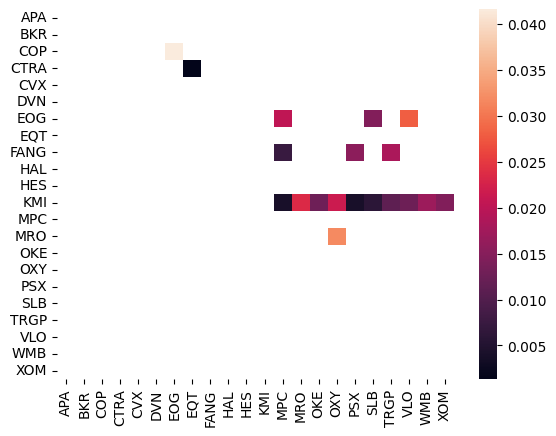

In [5]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
sns.heatmap(pvalues, xticklabels=data.columns, yticklabels=data.columns, mask = (pvalues >= 0.05))
print(pairs)

In [6]:
# We identify two possible stocks that may be cointegrated and confirm this
S1 = data['EOG']
S2 = data['COP']

score, pvalue, _ = coint(S1, S2)
print(pvalue)

0.010053296441997369


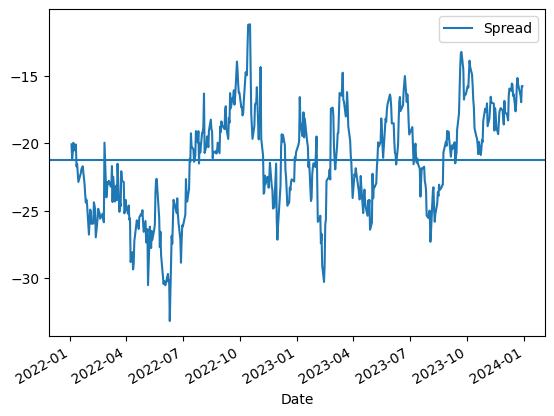

In [7]:
# Determine the spread and plot it to see if it moves around a mean
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['EOG']
b = results.params['EOG']

spread = S2 - b*S1
spread.plot()
plt.legend(['Spread'])
plt.axhline(spread.mean())

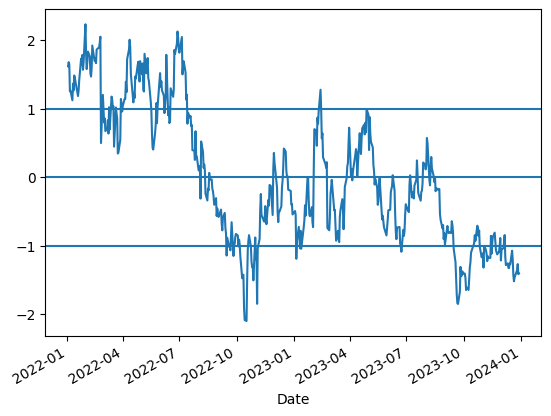

In [8]:
from numbers import Rational
# Define the z score and plot it for the ratio of the prices
def zscore(series):
  return (series - np.mean(series))/np.std(series)

ratio = S1/S2
zscore(ratio).plot()
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0)
plt.axhline(-1.0)
plt.show()

In [9]:
# Now we want to obtain training and testing data, do an 80-20 split
proportions = data['EOG']/data['HAL']
print(len(proportions)*0.8)

400.8


In [10]:
train_data = proportions[:320]
test_data = proportions[320:]

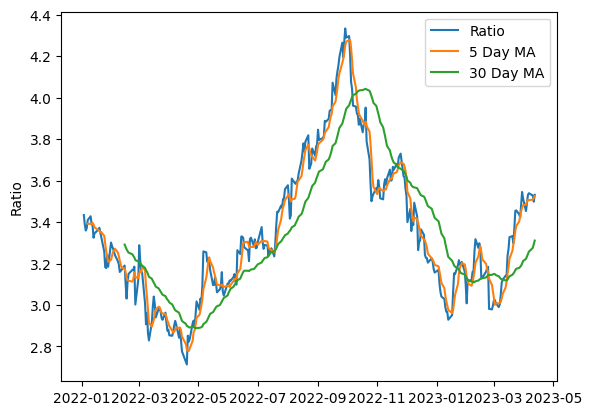

In [11]:
# We need to know what features are importatnt in determining the direction of the ratio. The moving averages and related metrics may be relevant
# Consider the 30 and 5 day Moving Average of the ratio, the 60 day standard deviation and the z score
ratios_ma30 = train_data.rolling(window=30, center =False).mean()
ratios_ma5 = train_data.rolling(window=5, center = False).mean()
ratios_std = train_data.rolling(window=30, center = False).std()
z_score_30_5 = (ratios_ma5 - ratios_ma30)/ratios_std
plt.figure()
plt.plot(train_data.index, train_data.values)
plt.plot(ratios_ma5.index, ratios_ma5.values)
plt.plot(ratios_ma30.index, ratios_ma30.values)
plt.legend(['Ratio', '5 Day MA', '30 Day MA'])
plt.ylabel('Ratio')
plt.show()

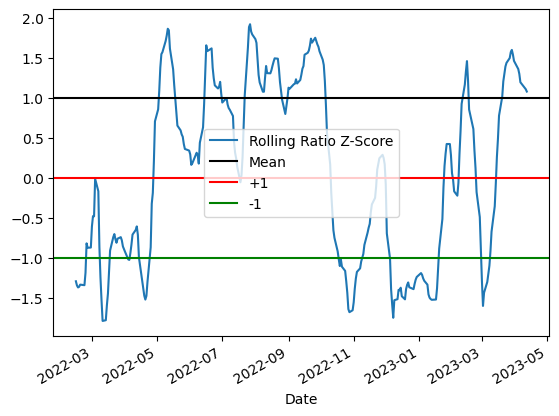

In [12]:
plt.figure()
z_score_30_5.plot()
plt.axhline(1.0, color='black')
plt.axhline(0, color='red')
plt.axhline(-1.0, color='green')
plt.legend(['Rolling Ratio Z-Score', 'Mean', '+1', '-1'])
plt.show()

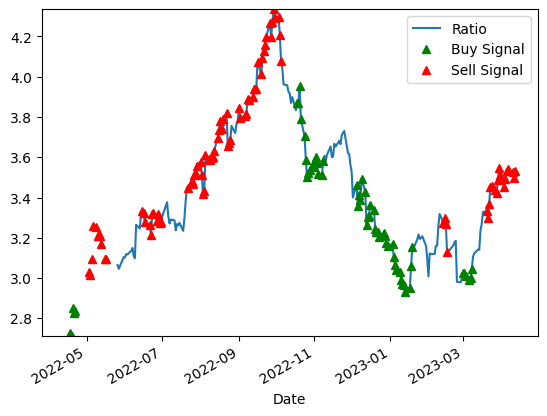

In [13]:
# Now we can use our model on actual data
plt.figure()
train_data[100:].plot()
buy= train_data.copy()
sell = train_data.copy()
buy[z_score_30_5>-1] = 0
sell[z_score_30_5<1] = 0
buy[70:].plot(color='green', linestyle = 'None', marker = '^')
sell[70:].plot(color='red', linestyle = 'None', marker = '^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, proportions.min(), proportions.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


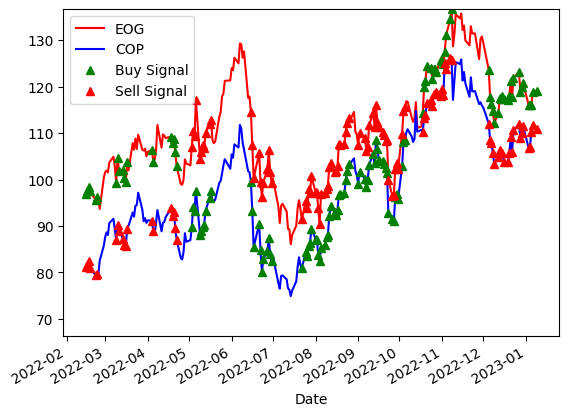

In [14]:
plt.figure()
S1 = data['EOG'].iloc[:256]
S2 = data['COP'].iloc[:256]

S1[30:].plot(color='red')
S2[30:].plot(color='blue')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy EOG and sell COP
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell EOG and buy COP
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[30:].plot(color='green', linestyle = 'None', marker = '^')
sellR[30:].plot(color='red', linestyle = 'None', marker = '^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.legend(['EOG', 'COP', 'Buy Signal', 'Sell Signal'])
plt.show()

In [16]:
def metrics(S1, S2, window1, window2):
  # If the window is 0 then return 0
  if (window1 == 0) or (window2 == 0):
    return 0
  # Determine the rolling mean and std
  ratios = S1/S2
  ma1 = ratios.rolling(window=window1, center =False).mean()
  ma2 = ratios.rolling(window=window2, center = False).mean()
  std = ratios.rolling(window=window2, center = False).std()
  # Calculate the z score
  z_score = (ma1 - ma2)/std

  # Simulate the trading with no profit or initial position
  profit = 0
  countS1 = 0
  countS2 = 0
  money = [1]
  for i in range(len(ratios)):
    if z_score[i] < -1:
      profit += S1[i] - S2[i] *ratios[i]
      countS1 -= 1
      countS2 += ratios[i]
      money.append(money[-1]+S1[i] - S2[i] *ratios[i])
    elif z_score[i] > 1:
      profit -= S2[i] - S1[i] *ratios[i]
      countS1 += 1
      countS2 -= ratios[i]
      money.append(money[-1]- S2[i] + S1[i] *ratios[i])
    elif abs(z_score[i] < 0.75):
      profit += S1[i] * countS1 + S2[i] * countS2
      countS1 = 0
      countS2 = 0
      money.append(money[-1]+S1[i] * countS1 + S2[i] * countS2)
  money = np.array(money)
  # Sharpe Ratio
  returns = np.diff(money)/money[:-1]
  sharpe = np.mean(returns)/np.std(returns)
  # Maximum Drawdown
  peak = np.argmax(money)
  trough = np.argmin(money[peak:]) + peak
  max_dd = (money[trough] - money[peak])/money[peak]
  # Relative Drawdown
  rel_dd = (money[-1] - money[0])/money[0]
  # Cumulative Returns
  cum_returns = (money[-1] - money[0])/money[0]

  return (sharpe, max_dd, rel_dd, cum_returns)


In [17]:
metrics(data['EOG'].iloc[256:], data['COP'].iloc[256:], 30, 5)

(0.083985787070787, 0.0, 1427.0619787614453, 1427.0619787614453)